Remaining items:
- docstring hunt for patch rulesnd citations
- update path handling

# Skymaps Overview

In this notebook, we will discuss:
- Ring Skymaps (the lsst.skymap class to which our original LSST skymap belongs)
- Some basic properties of ring skymaps
- The definitions and differences of tracts (inner region), tracts (outer polygons), and patches

In [3]:
from skymap_convert._internal.examples import demo_rings_plot, demo_rings_tracts_plot

## The anatomy of a ring skymap

In a ring skymap, we divide the sky (which is unfortunately spherical) into horizontal rings.

The LSST skymap has over 200 rings. For illustrative purposes, let us imagine a skymap with 5 rings:

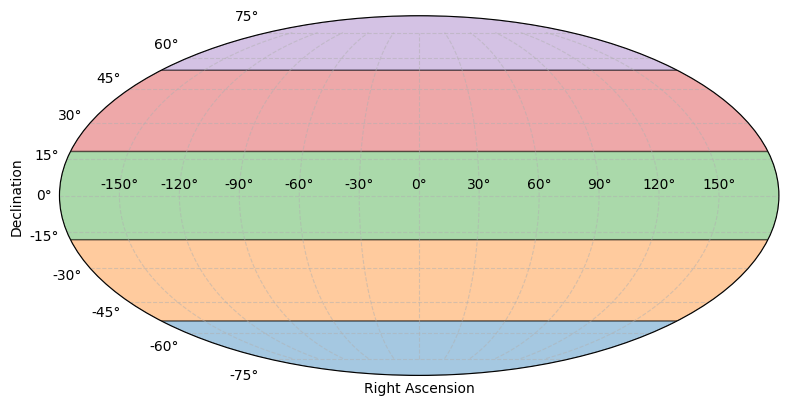

In [4]:
demo_rings_plot()

Then, we divide each of those things into tracts (inner region).

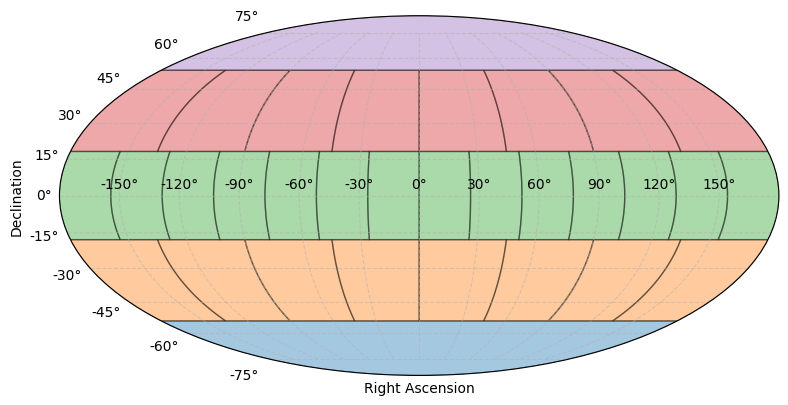

In [5]:
demo_rings_tracts_plot()

Some basic properties of tracts (inner region) are:
- They have the same area and dimensions as the other patches. <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)
- There are no gaps or overlaps between all the patches in a tract. <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2)
- Patches *do* need spherical geometry/knowledge of the WCS to calculate. So, these are the reason we've made our converted skymaps be a vertex dump, rather than the lighter-weight legacy RingOptimized version.

<a name="cite_note-1"></a>1. [^](#cite_ref-1) TODO grab the docstring that describes this, if possible  
<a name="cite_note-2"></a>2. [^](#cite_ref-2) TODO grab the docstring that describes this, if possible 

Note that patches can and do "overflow" beyond the boundaries of the tract (inner region).

Let's take a look at some tracts and patches from our skymap.

First, let's load the skymap reader.

In [6]:
from pathlib import Path

from skymap_convert._internal.examples import plot_patches_in_tract
from skymap_convert import ConvertedSkymapReader

package_root = Path.home() / "skymap-convert"
converted_skymap_path = package_root / "converted_skymaps" / "lsst_skymap"

reader = ConvertedSkymapReader(converted_skymap_path)

Now, let's take a look at a tract near the equator.

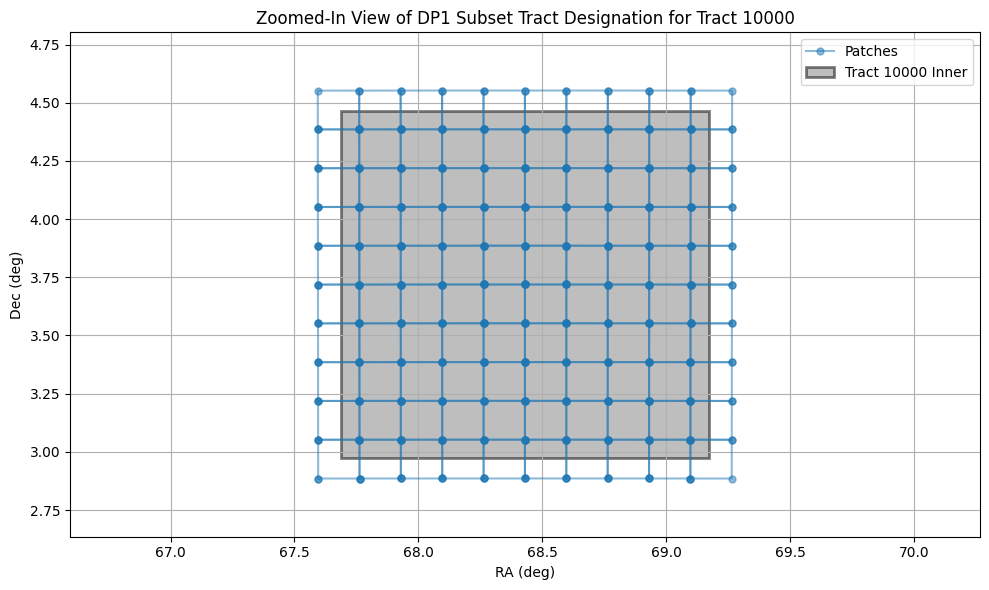

In [7]:
plot_patches_in_tract(reader, 10_000)

Note that tracts become more degenerate as we approach either of the poles ~~(because spheres are evil)~~.

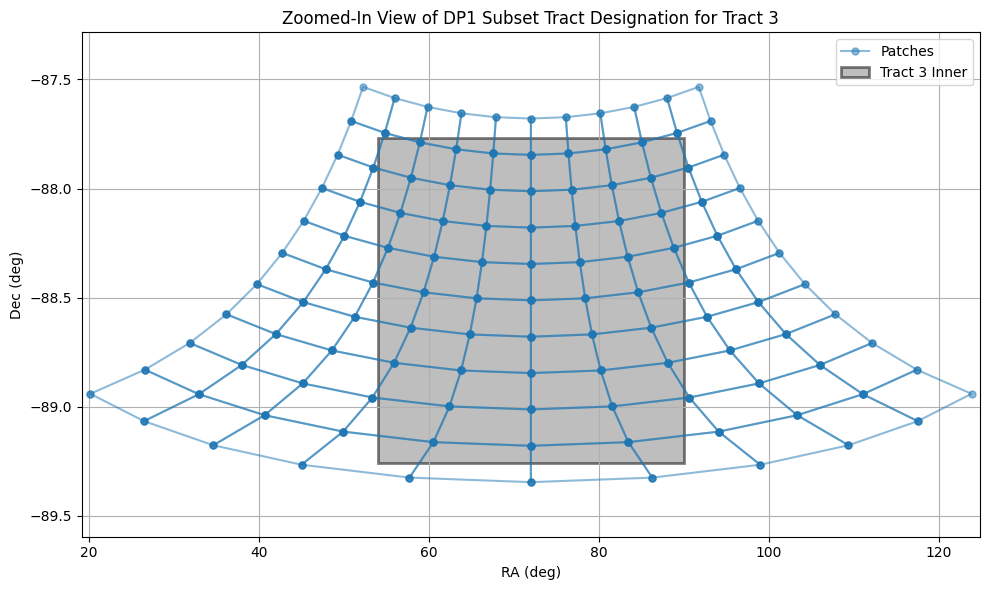

In [8]:
plot_patches_in_tract(reader, 3)

 If we draw a boundary based on the outside boundary of all the patches in a tract, we get the bounds of the tract (outer polygon).  

 However, tract (outer polygon) seems to be pretty useless to know—but we mention it so we don't get it confused with tract (inner region).

## Applied to DP1 tract classifications

 Based on a quick sketch with DP1 data, the tract that an object is assigned to appears to be based on the tract (inner region).

*ASK NEVEN: This is ok, right, if we make sure to only show ra/dec (and no prints) of a limited number of points?*

In [9]:
import lsdb

In [10]:
from dask.distributed import Client

client = Client(n_workers=4, memory_limit="auto")

In [11]:
dp1_object_collection = lsdb.open_catalog(
    "/sdf/data/rubin/shared/lsdb_commissioning/hats/v29_0_0/dia_object_collection",
    columns=["dec", "ra", "tract"],
)
dp1_object_box = dp1_object_collection.box_search(ra=[37.75, 40.0], dec=[6.0, 7.75])

In [12]:
dp1_computed = dp1_object_box.compute()

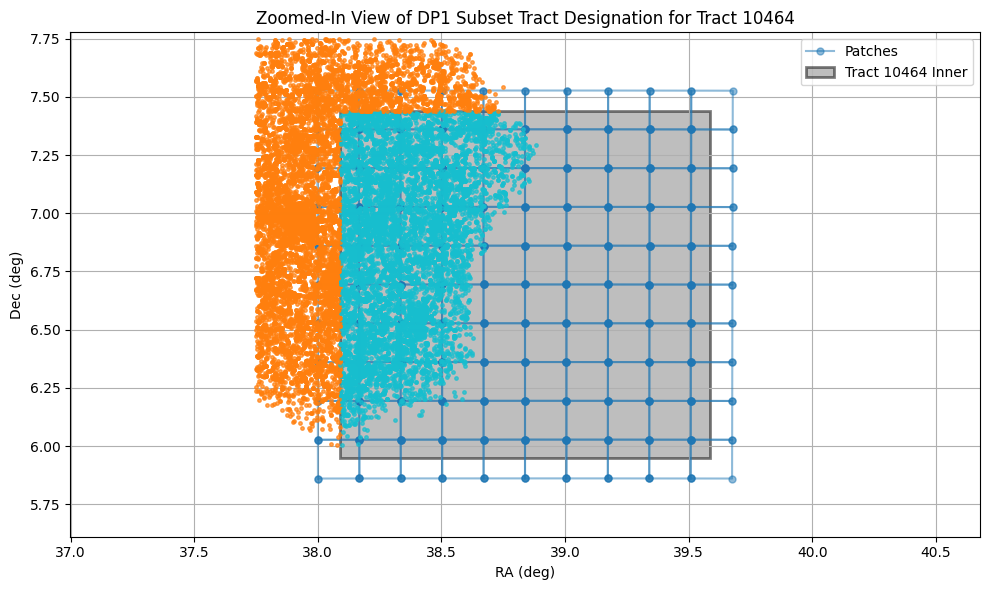

In [13]:
plot_patches_in_tract(reader, 10464, data=dp1_computed)

Since tracts (inner region) are designed such that they cover the entire (~~stupidly spherical~~) sky with no gaps or overlaps, we can infer the existence of a surjective function mapping from the set of all possible radec sphere coordinates to the set of tracts in our skymap.

That is to say, if we have a radec coordinate, we have exactly one tract to which it corresponds. Neat!

## About  

**Author:** Olivia Lynn

**Last updated on:** July 11, 2025